Student Name: Paul Minogue

Student ID: 21196354

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
import time

%matplotlib inline

## EDA - Exploratory Data Analysis

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [3]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [4]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [5]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

In [6]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

The `asymmetry coefficient` column is the only one with noticeable outliers, though they are not extreme outliers. &ensp; We will apply log transformation to it followed by `RobustScaler`. &ensp; To all other predictor columns we will apply `StandardScaler`. 

## Data Preparation

A binary classifier is to be used, but there are three distinct classes in the dataset. &ensp; The plan then is to combine `class 2` and `class 3` into a single class and use the classifier to distinguish between `class 1` and the combined `class 2 + class 3`.

In [7]:
mapper = {1: 1, 2: 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the three columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [8]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. &ensp; This is the reason, we stored the names of the columns in lists above. &ensp; We will use the following class in the preprocessing pipeline to put the names of the columns back. &ensp; We need this to easily apply the different preparation strategies to the two groups of columns. 

In [9]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. &ensp; It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). &ensp; Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`. 

In [11]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets.

In [12]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. &ensp; That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. &ensp; To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. &ensp; The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [13]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid

param_grid = {
    'svm__C': [0.1, 1, 10, 50, 75, 100, 120],  
    'svm__gamma': [15, 10, 5, 1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
svm_start = time.time()
search.fit(X_train, y_train) #training happens here!
svm_end = time.time()

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

print('Time taken: {0} seconds'.format(svm_end-svm_start))

Best CV score = 0.958:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Time taken: 17.780720949172974 seconds


The parameter `refit=True` makes the GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

Let's repeat the same experiment but with the Random Forest classifier.

In [14]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid

param_grid = {
    'rf__n_estimators' : [15, 20, 25, 30, 35, 40, 45],
    'rf__max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
rf_start = time.time()
search.fit(X_train, y_train) #training happens here!
rf_end = time.time()

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

print('Time taken: {0} seconds'.format(rf_end-rf_start))

Best CV score = 0.934:
Best parameters:  {'rf__max_depth': 5, 'rf__n_estimators': 20}
Time taken: 10.487431764602661 seconds


## MLP Classifier

A multi-layer perceptron is chosen as an additional classifier. &ensp; The activation type, layer sizes, and regularization parameter were varied in order to find the best set of parameters.

In [15]:
from sklearn.neural_network import MLPClassifier

In [16]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier())])

# prepare a prameter grid

param_grid = {
    'mlp__activation': ['logistic', 'tanh', 'relu'],
    'mlp__hidden_layer_sizes': [(2,3), (3,2), (3,3)],
    'mlp__learning_rate_init': [0.001],
    'mlp__max_iter': [4000],
    'mlp__alpha': [0.0001, 0.0005, 0.001]}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
mlp_start = time.time()
search.fit(X_train, y_train) #training happens here!
mlp_end = time.time()

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

print('Time taken: {0} seconds'.format(mlp_end-mlp_start))

Best CV score = 0.958:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (3, 3), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 4000}
Time taken: 54.47771978378296 seconds


## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [17]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [18]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [19]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

In [20]:
plt.rcParams["figure.figsize"]=10,5

In [21]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics,}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

The above comparisons would normally be very useful in practice, but they can be misleading without context. &ensp; Whether or not high precision or high recall is a desirable outcome depends almost entirely on how the trained model is to be used. &ensp; Just understanding the dataset itself isn't enough and it would need to be known what the consequences are of misclassifying a seed where the model is deployed.

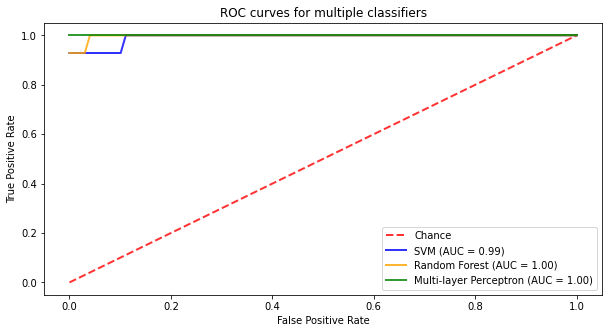

In [22]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='Multi-layer Perceptron (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

When using ROC curves to measure the performance of the classifiers, the MLP almost always seemed to come out on top, but only marginally. &ensp; Given that the seeds dataset is essentially a toy dataset with a fairly clean underlying structure, it isn't surprising that using Grid Search with a small number of parameters gives very good results.

One thing to note though about the MLP's success here is that it is a more expensive classifer to train with Grid Search due to there being a large number of useful parameters to try. &ensp; The SVM and Random Forest tend to take a similar amount of time to train as one another to get similar results, where as the MLP takes 3-4 times longer to marginally outperform them. &ensp; On a dataset this small and tidy, it doesn't matter much, but on a larger messy real world dataset, this additional time could be a much bigger deal.

## Train a Final Model

Finally, we can train an MLP model with all data we have, assuming that the more data we have the better the model.

In [23]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('mlp__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, MLPClassifier(**transform(MLP_best_params)))

final_model = pipe.fit(X, y)